This part will not be very comprehensive since it's not the main focus of this project. We will just quickly explore the relationship between the number of amenities in the various time groups and the walk score. To do this, we first try a simple linear regression and then a random forest regression. As usual, we load the libraries and the data:

In [9]:
import geopandas as gpd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#plt.style.use('dark_background')
%matplotlib inline

In [2]:
statistical_areas = gpd.read_file('../dataset/statistical_areas.geojson')

In [16]:
def saveImage(ax, title, filename):
    ax.set_title(title, fontdict={"fontsize": "18", "fontweight" : "3"})
    ax.get_figure().savefig(f'../images/{filename}.png', dpi=150, bbox_inches='tight')
    return ax

Like anticipated, we start with a simple linear regression. The coefficients are the number of amenities within 15, 10 and 5 minutes. The response variable is the walk score. We also scale the samples to normalize the data:

In [3]:
sc = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(
    statistical_areas[['within_15_minutes', 'within_10_minutes', 'within_5_minutes']], statistical_areas['walk_score'], test_size=0.2, random_state=226506)

X_train = sc.fit(X_train).transform(X_train)
X_test = sc.transform(X_test)


linear_regression = LinearRegression().fit(X_train, y_train)

In [4]:
linear_regression_predictions = linear_regression.predict(X_test)

print("Coefficients: \n", linear_regression.coef_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, linear_regression_predictions))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, linear_regression_predictions))

Coefficients: 
 [ 28.69136448 -26.53449347  12.87731118]
Mean squared error: 577.24
Coefficient of determination: 0.21


The result is very poor. The coefficient of determination is calculated with the r2 score, and ideally should be as close to 1 as possible. Here it is only 0.21. The mean squared error is also very high. We can plot the model to visualize the results:

<AxesSubplot: title={'center': 'Linear Regression'}, xlabel='Real Walk Score', ylabel='Predicted Walk Score'>

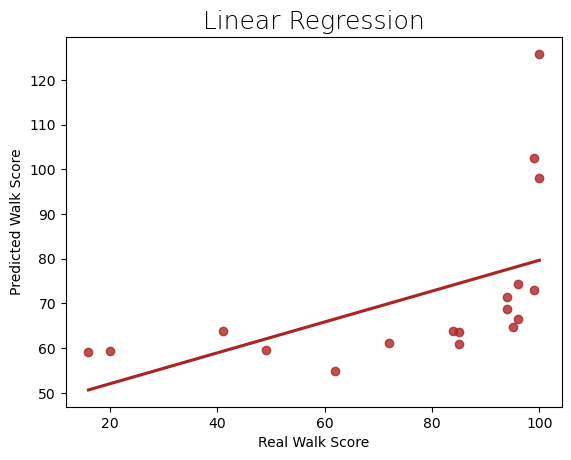

In [17]:
ax = sns.regplot(x=y_test,y=linear_regression_predictions,ci=None,color ='#AB2525')
ax.set_xlabel('Real Walk Score')
ax.set_ylabel('Predicted Walk Score')

ax = saveImage(ax, 'Linear Regression', 'linear_regression')
plt.show()

We now try with a random forest. We test a number of parameters to ensure that the best fit is achieved:

In [10]:
tune_grid = {
    'criterion': ['squared_error', 'absolute_error'],
    'n_estimators': [200, 300, 400, 500, 600, 700, 800],
    'max_features': ['sqrt','log2'],
    'max_depth' : [1,2,3,4,5],
}

tuned_rf = GridSearchCV(RandomForestRegressor(
    random_state=226506), tune_grid, cv=10, verbose=1)
tuned_rf.fit(X_train, y_train)

preds_rf = tuned_rf.predict(X_test)

Fitting 10 folds for each of 140 candidates, totalling 1400 fits


In [11]:
tuned_rf.best_params_

{'criterion': 'absolute_error',
 'max_depth': 5,
 'max_features': 'sqrt',
 'n_estimators': 600}

In [12]:
print("Mean squared error: %.2f" % mean_squared_error(y_test, preds_rf))
print("Coefficient of determination: %.2f" % r2_score(y_test, preds_rf))

Mean squared error: 127.54
Coefficient of determination: 0.83


The performance here is much better, achieving more than 0.8 on the r2 score. Once again, we visualize the predictions:

<AxesSubplot: title={'center': 'Random Forest'}, xlabel='Real Walk Score', ylabel='Predicted Walk Score'>

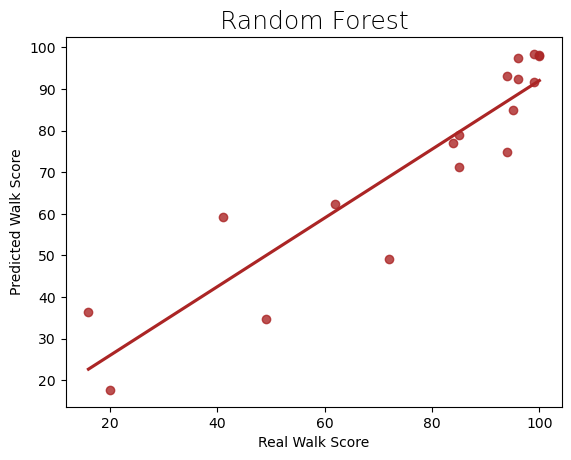

In [18]:
ax = sns.regplot(x=y_test,y=preds_rf,ci=None,color ='#AB2525')
ax.set_xlabel('Real Walk Score')
ax.set_ylabel('Predicted Walk Score')

ax = saveImage(ax, 'Random Forest', 'random_forest')
plt.show()

Before proceeding to the spatial analysis, we also check the feature importance for the model:

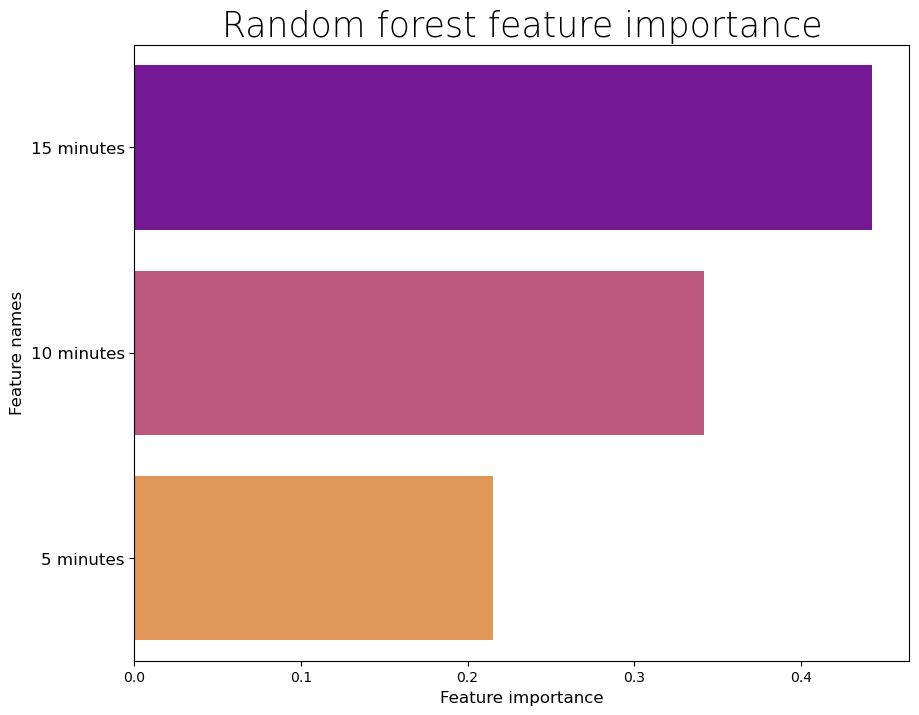

In [29]:
def plot_feature_importance(importance,names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], palette='plasma')
    plt.title('Random forest feature importance', fontdict={"fontsize": "25", "fontweight" : "3"})
    plt.xlabel('Feature importance', fontdict={"fontsize": "12"})
    plt.ylabel('Feature names', fontdict={"fontsize": "12"})
    plt.yticks([0,1,2],['15 minutes', '10 minutes', '5 minutes'], fontdict={"fontsize": "12"})
    plt.savefig('../images/feature_importance.png', dpi=150, bbox_inches='tight')


plot_feature_importance(tuned_rf.best_estimator_.feature_importances_,['within_15_minutes', 'within_10_minutes', 'within_5_minutes']) 

Here we see how the number of amenities within 15 minutes are still the most important, confirming the result found previously when calculating the correlation.

While the result obtained is decent, this is not an extensive application of Machine Learning methods, but only a test to confirm previous findings. The fact that the predictions look to be more precise for high values and worse for smaller values is because, as we saw in the previous phase, the distribution is skewed towards higher values. For something more precise, but out of the scope of this project, we should have taken into consideration potential outliers, tested a broader range of parameters, added maybe some synthetic data and so on.